<table>
<table border = 5  align = center bgcolor="white" cellspacing="10px">

<tr>
<td><a href="https://drive.google.com/file/d/1--wnF2vQE2nDQ8rC8iMa2A2Sk1tNwPwz/view?usp=sharing"> <img alt="Colaboratory logo" width="150px"  src="https://miro.medium.com/max/986/1*S2AyJcdw8EPcn7gwDVSBCA.png" align="left" hspace="10px" vspace="0px" /> </a> </td>
   
    
 
<td></td>
    
<td><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitmilab.redclara.net%2FhalleyUIS%2Fmoncora.git/4d1344cb6f0df9a23bce6fe9d70812719aeb0fe5?urlpath=lab%2Ftree%2FBook%2FJupyter_Notebooks%2FDatosII_a.ipynb"><img src="https://mybinder.org/static/images/logo_social.png" alt="Alternative text" width="150px"  /></a>
</td>

</tr>

</table>
    
<br>

---
    
# <strong>Los datos hablan II. Visualización de datos. Ventaneo y Resampleo</strong>

In [ ]:
!pip install APIMakeSens

In [1]:
import pandas as pd                   # Librería de manejo de datos en DataFrames
import numpy as np                    # Librería de cálculos matemáticos con Arrays
import matplotlib.pyplot as plt       # Librería de gráficas
import matplotlib.dates as mdates     # Módulo de manejo de fechas en las etiquetas de una gráfica
from MakeSens import MakeSens         # Libería de descarga de datos del proyecto RACIMO-MONCORA

## **Importación de datos**

In [3]:
fecha_inicio = "2023-09-04 00:00:00"
fecha_fin = "2023-10-04 23:59:00"
estacion = "mE1_00008"                      # FCUIS: 'mE1_00008'
frecuencia = "6H"                          # 1T: 1 unidad de tiempo / 1 minuto, 1H: 1 hora, 1D: 1 día

data = MakeSens.download_data(estacion, fecha_inicio, fecha_fin, frecuencia)

## **Selección de datos Material Particulado**

In [4]:
# Selección de columnas
columnas = ["pm10_1", "pm10_2","pm25_1", "pm25_2", "pm1_1", "pm1_2", 'ts']
pm_data = data[columnas]

# Ajuste del índice de la tabla de datos. Ponemos el tiempo como índice:
pm_data = pm_data.set_index('ts')
pm_data.index = pd.to_datetime(pm_data.index)

#pm_data

## **Limpiando datos**

Para que sea un poco más sencillo manejar nuestros datos, definiremos un nuevo DataFrame para almacenar solo con las variables de material particulado. Luego convertiremos el índice de los datos a formato de fecha y hora con la función ```to_datetime()```.

In [5]:
columnas = pm_data.columns # Guardamos los nombres de las columnas en una lista
for col in columnas:                                             # Iteramos entre cada columna
    pm_data[col] = pm_data[col].where(pm_data[col]<120, np.nan)  # Reemplazamos los valores mayores a 120 por NaN

In [6]:
show = False         #  Muestra la grafica si es verdadero.
if show:
    # Graficamos los datos limpios de pm10 
    fig = plt.figure(figsize=(12, 6))            # Figura
    ax = fig.gca()                               # Ejes
    plt.plot(pm_data.index, pm_data['pm10_1'], '.',label = 'Sensor 1', alpha=0.7)   # Datos pm10_1
    plt.plot(pm_data.index, pm_data['pm10_2'], '.',label = 'Sensor 2', alpha=0.7)   # Datos pm10_2

    # Configuramos etiquetas
    plt.title("Datos de PM 10", fontsize=20)
    plt.xlabel("Fecha",         fontsize=15)
    plt.ylabel(r"Concentración [$\mu g/m^3$]", fontsize=15)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))     # Formato de fecha: %b: mes, %d: día, %Y: año
    plt.grid(alpha=0.5, linestyle="--")
    plt.legend(fontsize=12)
    plt.show()

## **Media móvil**

In [7]:
ventana = 24         # Tamaño de la ventana en cantidad de datos
min_periods = 5        # Mínimo numero de datos en una ventana para calcular el promedio, de lo contrario el resultado es np.nan
for col in columnas:
    pm_data[col+'_r'] = pm_data[col].rolling(window=ventana, min_periods=min_periods).mean()  #Calculemos la media móvil

## **Visualización de datos**

Veamos qué más podemos hacer con los datos. De momento, vamos a promediar los datos utilizando la función ```.resample()``` de Pandas. Esta función nos permite agrupar los datos por intervalos de tiempo. En este caso, vamos a agrupar los datos cada 3 días. La diferencia entre ```.resample()``` y ```.rolling()``` es que ```.resample()``` agrupa los datos en **intervalos de tiempo**, mientras que ```.rolling()``` agrupa los datos en **ventanas de tiempo.** 

> ¿Qué diferencia hay entre agrupar los datos en intervalos de tiempo y agruparlos en ventanas de tiempo?

In [8]:
#Establecer frecuencia
dat = pm_data.resample('3D').mean()

#Calcular desviación estandar
dat2 = pm_data.resample('3D').std()

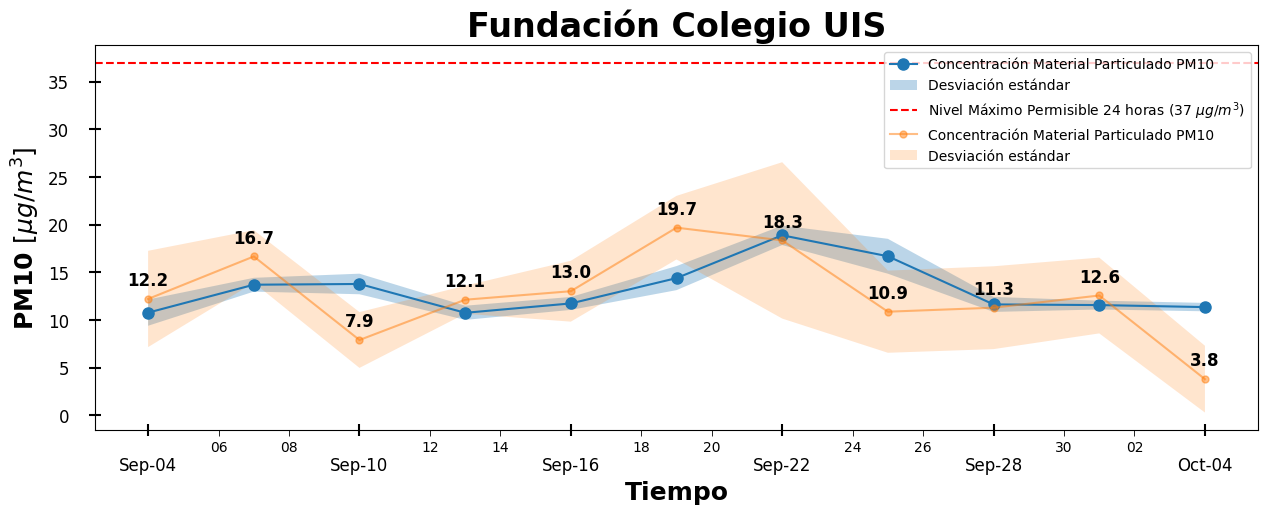

In [14]:
#The recommendation of WHO is 25 μg/m3 daily average, 35 μg/m3 by US EPA, and 50 μg/m3 by Vietname Environmental Administration
# Crear gráfico
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()

# Graficas
plt.plot(dat.index,              dat['pm10_1_r'], '-o', label='Concentración Material Particulado PM10', markersize=8)
plt.fill_between(dat.index, y1 = dat['pm10_1_r']-dat2['pm10_1_r'], y2 = dat['pm10_1_r'] + dat2['pm10_1_r'], alpha=0.3,label='Desviación estándar')
plt.axhline(y=37, color='r', linestyle='--', label='Nivel Máximo Permisible 24 horas (37 $\mu g /m^3$)') ## Nivel máximo permisible

## Usando solo resample
plt.plot(dat.index, dat['pm10_1'],   '-o', label='Concentración Material Particulado PM10', markersize=5, alpha=0.5)
plt.fill_between(dat.index, y1 = dat['pm10_1']-dat2['pm10_1'],     y2 = dat['pm10_1'] + dat2['pm10_1'],     alpha=0.2, label='Desviación estándar')

# Añadir etiquetas con valores en cada punto
for x, y in zip(dat.index, dat.pm10_1):
    plt.text(x, y+1, f"{y:.1f}", ha="center", va="bottom", #ha: alineamiento horizontal, va: alineamiento vertical
            fontsize=12, fontweight="bold")

plt.legend(loc='upper right')

# Configurar títulos y etiquetas de los ejes
plt.title("Fundación Colegio UIS", fontsize=24, fontweight="bold"); plt.xlabel("Tiempo", fontsize=18, fontweight="bold")
plt.ylabel("PM10 $[\mu g / m^3]$", fontsize=18, fontweight="bold")

# Personalizar el formato de las etiquetas del eje x
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d')); ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=6));   ax.xaxis.set_minor_locator(mdates.DayLocator(interval=2))
ax.tick_params(which='major', pad=15, length=8, labelsize=12, direction="inout", width=1.5); ax.tick_params(which='minor', length=4)
plt.show()

En este **ejemplo**, hemos graficado la variación del $PM_{10}$ a lo largo de los días. La zona sombreada hace referencia a la desviación estándar de los datos.

Ahora bien, es importante saber aplicar los conocimientos que hemos adquirido del lenguaje de programación. Para facilitar el trabajo, podemos crear **funciones** que nos ayuden a realizar **tareas repetitivas**. En este caso, podemos crear una función que nos permita **graficar** la **variación de los datos** a lo largo del día.

In [15]:
#Podemos hacer funciones para reducir el trabajo
def grafica(ax,dat,dat_std,columna,label,titulo,xlabel,ylabel,y_max, color=['blue','red'],alpha=0.5,unit_text=1,locator='day'):
    """
    @params
        ax : axis
             Eje de una figura
        dat : dataframe
              Set de datos
        dat_std : dataframe
              Set de datos de desviación estándar
        columna : str
                  Nombre de la columna de datos
        label : str
                Etiqueta del conjunto de datos
        titulo : str
                 Nombre del título del grafico
        xlabel : str
                 Etiqueta eje x
        ylabel : str
                 Etiqueta eje y
    @ejemplo
        >> fig, ax = plt.subplots(figsize=(12,6))
        >> label = 'Concentración Material Particulado PM2.5'
        >> titulo = 'Instituto Técnico Damazo Zapata'
        >> xlabel = 'Tiempo'
        >> ylabel = 'PM2.5 $[\mu g / m^3]$'
        >> grafica(ax, dat, dat_std, 'pm25_1_AE', label, titulo,xlabel,ylabel)
        >> plt.show()
    """

    ## Graficar datos 
    ax.plot(dat.index, dat[columna], '-o', label=label, color=color[0])
    ax.fill_between(dat.index, dat[columna]+dat_std[columna],dat[columna]-dat_std[columna],alpha=alpha,color=color[1],label='Desviación estándar')

    ## Agregar etiquetas a cada punto de datos
    for x, y in zip(dat.index, dat[columna]): 
        plt.text(x, y+unit_text, f"{y:.1f}", ha="center", va="bottom", #ha: alineamiento horizontal, va: alineamiento vertical
                fontsize=12, fontweight="bold") 

    ## Configurar título, etiquetas, leyenda y límite del eje 'y'
    ax.set_title(titulo,  fontsize=20, fontweight="bold")     # Titulo
    ax.set_xlabel(xlabel, fontsize=15, fontweight="bold")     # Etiqueta eje x
    ax.set_ylabel(ylabel, fontsize=15, fontweight="bold")     # Etiqueta eje y
    
    ## Configurar límites y escalas de los ejes 
    dat_min = (dat[columna]-dat_std[columna]).min()  # Mínimon valor del grafico
    dat_max = (dat[columna]+dat_std[columna]).max()  # Máximo valor del grafico
    if dat_min>0: 
        dat_min*=0.9
    else: 
        dat_min*=1.1
    ax.set_ylim(dat_min, dat_max*1.1)                # Límites eje y
    if dat_max*1.1 > y_max:                       # Graficamos la línea de nivel máximo permisible solo si está por debajo del valor máximo de la gráfica
        plt.axhline(y=y_max, color='r', linestyle='--', label="Nivel Máximo Permisible 24 horas ({} $\mu g /m^3$)".format(y_max)) # Línea horizontal
    ax.legend(loc='upper right')

    ## Convertir las fechas de las etiquetas del eje x a formato Mes-día
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    if locator=='day':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    if locator=='month':
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.tick_params(which='major', pad=15, length=8, labelsize=12, direction="inout", width=1.5)
    ax.tick_params(which='minor', length=4)

Una vez hemos creado nuestra función, podemos utilizarla para graficar la variación de los datos de $PM_{1}$, $PM_{2.5}$ y $PM_{10}$ a lo largo del mes.

/tmp/ipykernel_3444/1764770885.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(121)


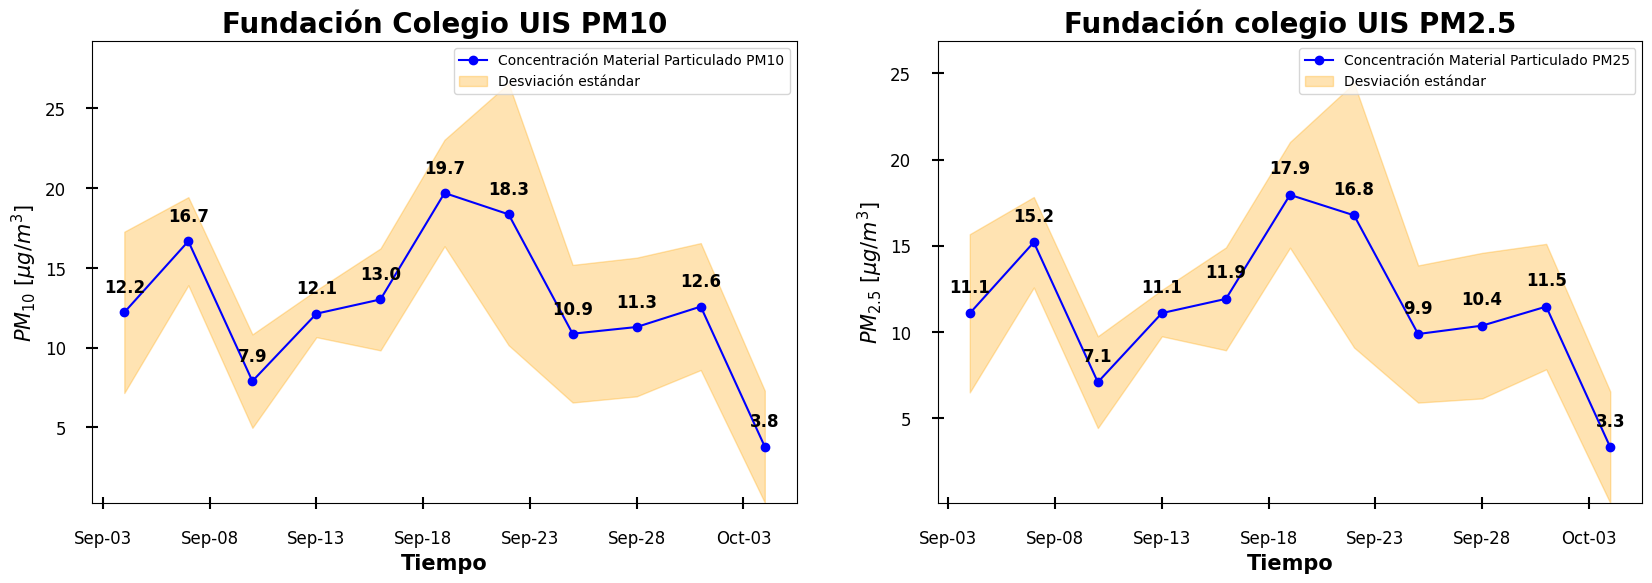

In [16]:
# Probemos la función que hemos creado
fig = plt.subplots(figsize=(20,6))

ax = plt.subplot(121)
label = 'Concentración Material Particulado PM10'
titulo = 'Fundación Colegio UIS PM10'
xlabel = 'Tiempo'
ylabel = '$PM_{10} ~ [\mu g / m^3]$'
alpha=0.3
color=["Blue", "Orange"]
y_max = 37
grafica(ax, dat, dat2,'pm10_1', label, titulo,xlabel,ylabel, y_max, color,alpha)

ax = plt.subplot(122)
titulo = 'Fundación colegio UIS PM2.5'
label = 'Concentración Material Particulado PM25'
ylabel = '$PM_{2.5}~[\mu g / m^3]$'
y_max = 37
grafica(ax, dat, dat2,'pm25_1', label, titulo,xlabel,ylabel, y_max, color,alpha)
ax.axhline(y=37, color='r', linestyle='--', label="Nivel Máximo Permisible 24 horas (37 $\mu g /m^3$")
plt.show()

#### Sub-gráficas
Tenemos tres tipos de material particulado, cada uno de ellos medidos con dos sensores. Debemos  saber si los dos sensores de cada tipo de material particulado miden lo mismo. Para esto, realizaremos un promedio entre dichas medidas usando ```.mean()``` y ```.resample()``` de Pandas.

In [17]:
# Sacamos un promedio de los datos de los sensores para cada tipo de partícula
pm_data_mean = pd.DataFrame()
pm_data_mean["PM_1"] = pm_data[["pm1_1_r", "pm1_2_r"]].mean(axis=1)
pm_data_mean["PM_25"] = pm_data[["pm25_1_r", "pm25_2_r"]].mean(axis=1)
pm_data_mean["PM_10"] = pm_data[["pm10_1_r", "pm10_2_r"]].mean(axis=1)

Vamos a crear una ***gráfica*** compuesta de ***4 subgráficas***, una para cada tipo de material particulado y una última donde se muestren los datos de los 3 tipos de material particulado con la función ```.subplots()``` de Matplotlibs. A continuación, graficaremos el **material particulado promedio** por hora, por día y el material particulado registrado por cada sensor.



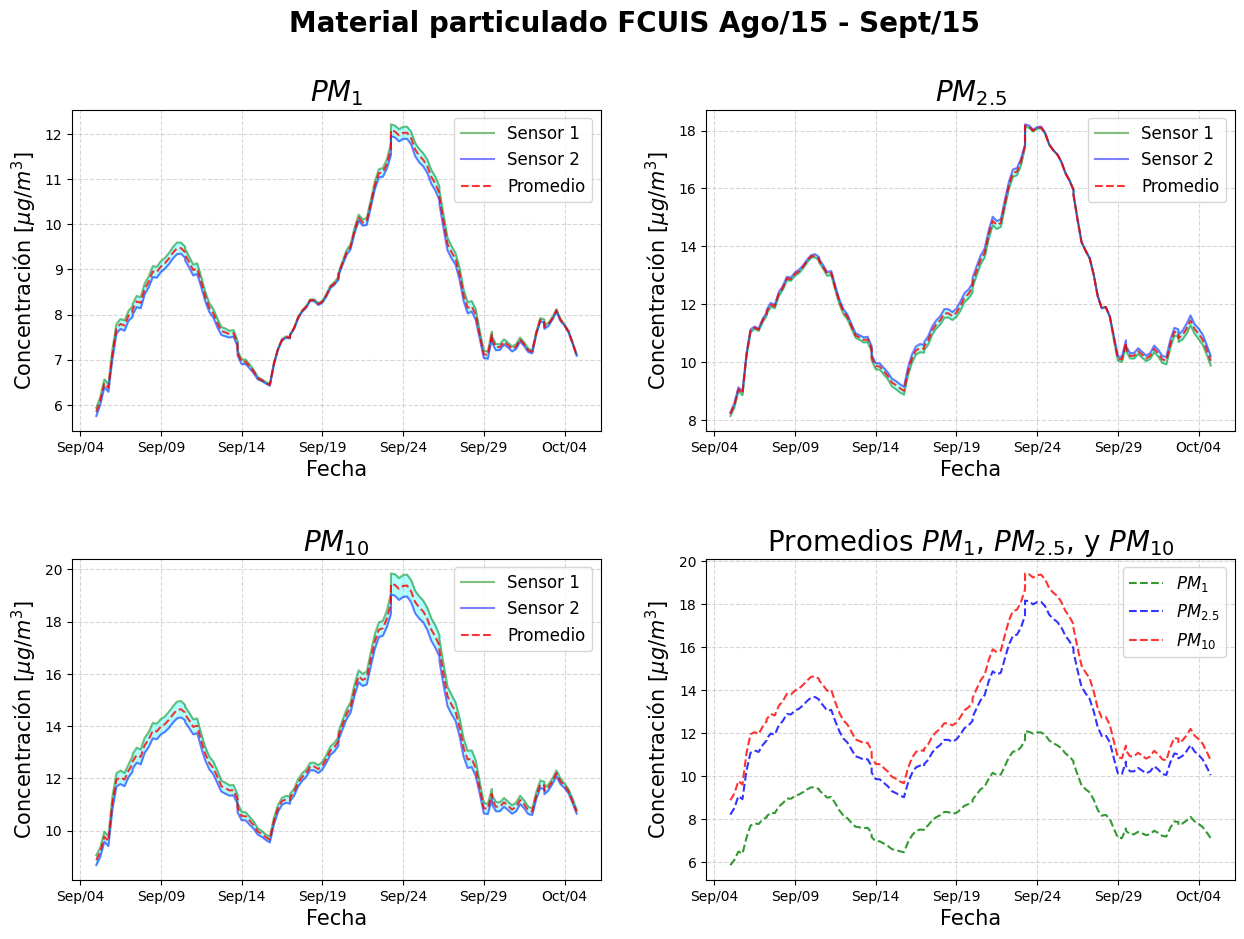

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))   # Creamos una figura con 4 subplots
fig.subplots_adjust(hspace=0.4)                  # Configuramos espacio entre los subplots

def grafica2(ax, columnas, labels):
    ax.plot(pm_data[columnas[0]],      label=labels[0], alpha=0.5, color="green")
    ax.plot(pm_data[columnas[1]],      label=labels[1], alpha=0.5, color="blue")
    ax.plot(pm_data_mean[columnas[2]], label=labels[2], alpha=0.8, color="red", linestyle="--")
    ax.fill_between(pm_data.index, pm_data[columnas[0]], pm_data[columnas[1]], color='cyan', alpha=0.3)
    
def ajusta_etiquetas(ax,titulo):
    ax.set_title(titulo, fontsize=20)
    ax.set_ylabel(r"Concentración [$\mu g/m^3$]", fontsize=15)
    ax.set_xlabel("Fecha", fontsize=15)
    ax.grid(alpha=0.5, linestyle="--")
    ax.legend(fontsize=12,loc='upper right')

## Graficamos los datos de PM 1
grafica2(ax[0,0],columnas=['pm1_1_r','pm1_2_r','PM_1'],labels=['Sensor 1', 'Sensor 2', 'Promedio'])
ajusta_etiquetas(ax[0,0], r'$PM_{1}$')

## Graficamos los datos de PM 2.5
grafica2(ax[0,1],columnas=['pm25_1_r','pm25_2_r','PM_25'],labels=['Sensor 1', 'Sensor 2', 'Promedio'])
ajusta_etiquetas(ax[0,1], r'$PM_{2.5}$')

## Graficamos los datos de PM 10
grafica2(ax[1,0],columnas=['pm10_1_r','pm10_2_r','PM_10'],labels=['Sensor 1', 'Sensor 2', 'Promedio'])
ajusta_etiquetas(ax[1,0], r'$PM_{10}$')

## Graficamos los promedios de los datos de PM 1, 2.5 y 10
ax[1,1].plot(pm_data_mean.PM_1, label=r"$PM_{1}$", alpha=0.8, color="green", linestyle="--")
ax[1,1].plot(pm_data_mean.PM_25, label=r"$PM_{2.5}$", alpha=0.8, color="blue", linestyle="--")
ax[1,1].plot(pm_data_mean.PM_10, label=r"$PM_{10}$", alpha=0.8, color="red" , linestyle="--")
ajusta_etiquetas(ax[1,1], r'Promedios $PM_{1}$, $PM_{2.5}$, y $PM_{10}$')

## Formateamos el eje de las fechas para los 4 subplots
for i in range(2):
    for j in range(2):
        ax[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%b/%d'))
        ax[i,j].xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.suptitle('Material particulado FCUIS Ago/15 - Sept/15',fontsize=20, fontweight="bold")
plt.show()

Ahora que tenemos nociones de cómo se comporta el material particulado, surgen ciertas preguntas:
- ¿Por qué el $PM_{1}$ es menor que el $PM_{2.5}$ y el $PM_{10}$?
- ¿Qué pasa con el material particulado en la noche?
- ¿Se comportará igual durante todo el mes o solo se trata de un caso particular?

Procedamos a realizar un análisis de los datos de material particulado por día de la semana: